In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 199 kB 57.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=6cb29b3e9db7c463a0796461e52ed8941b69c02582ede6f060035f4c7d959fcc
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
import pyspark
from pyspark import SparkContext

sc = SparkContext(master="local[2]")

In [85]:
from pyspark.sql.functions import col

In [86]:
from pyspark.sql import SparkSession

In [87]:
spark = SparkSession.builder.appName("BDACrimeClass").getOrCreate()

In [88]:
import pandas 
from pyspark.sql.functions import * 
from pyspark.ml import Pipeline 
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.classification import NaiveBayes 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

In [89]:
test = spark.read.csv('test.csv',header=True)
train = spark.read.csv('train.csv',header=True)

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

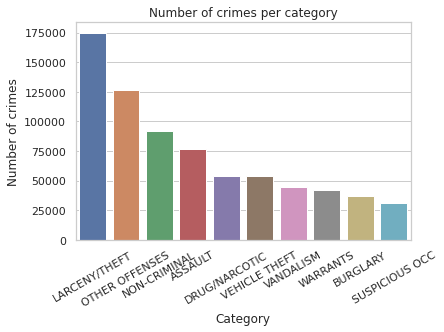

In [93]:
from pyspark.sql.functions import desc,col
Category=train.groupBy(train['Category']).count().orderBy(desc("count")).limit(10).toPandas()
plt.clf()
sns.set(style="whitegrid")
sns.barplot(x="Category", y="count", data=Category)
plt.title('Number of crimes per category')
plt.xlabel('Category')
plt.xticks(rotation=30)
plt.ylabel('Number of crimes')
plt.show()

In [94]:
District=train.groupBy(train['PdDistrict']).count().orderBy(desc("count")).toPandas()

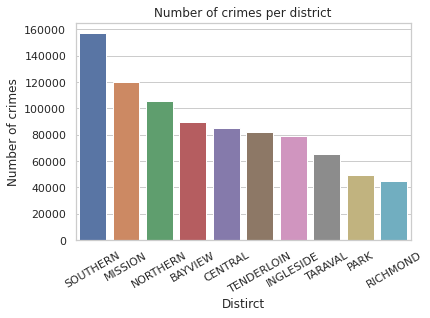

In [95]:
plt.clf()
sns.set(style="whitegrid")
sns.barplot(x="PdDistrict", y="count", data=District)
plt.title('Number of crimes per district')
plt.xlabel('Distirct')
plt.xticks(rotation=30)
plt.ylabel('Number of crimes')
plt.show()

In [ ]:
#from pyspark.sql.functions import hour, month, year
#train=train.withColumn("Hour",hour(train.Dates)).withColumn("Month",month(train.Dates)).withColumn("Year",year(train.Dates))

In [ ]:
#from pyspark.sql.functions import expr
#train=train.select('Category','DayOfWeek','PdDistrict','Address','X','Y','Hour','Month','Year')

In [ ]:
#test=test.withColumn("Hour",hour(test.Dates)).withColumn("Month",month(test.Dates)).withColumn("Year",year(test.Dates))
#test=test.select('Id','DayOfWeek','PdDistrict','Address','X','Y','Hour','Month','Year')

In [100]:
from pyspark.sql.functions import isnull, when, count
train.select([count(when(isnull(c), c)).alias(c) for c in train.columns]).show()

+-----+--------+--------+---------+----------+----------+-------+---+---+
|Dates|Category|Descript|DayOfWeek|PdDistrict|Resolution|Address|  X|  Y|
+-----+--------+--------+---------+----------+----------+-------+---+---+
|    0|       0|       0|        0|         0|         0|      0|  0|  0|
+-----+--------+--------+---------+----------+----------+-------+---+---+



In [10]:
cols = ("Descript","Resolution")
train1=train.drop(*cols)
test1=test.drop("Id")

In [11]:
train1 = train1.select(col('Dates'),
                       col('Category'),
                         col('DayOfWeek'),
                         col('PdDistrict'),
                         col('Address'),
                         col('X').cast('float'),
                         col('Y').cast('float'),
                        )

In [12]:
test1 = test1.select(col('Dates'),
                         col('DayOfWeek'),
                         col('PdDistrict'),
                         col('Address'),
                         col('X').cast('float'),
                         col('Y').cast('float'),
                        )

In [13]:
required_features = ['Dates1',
                     'DayOfWeek1',
                    'X1',
                    'Y1',
                    'PdDistrict1',
                    'Address1']

In [14]:
train1 = StringIndexer(
    inputCol='Dates', 
    outputCol='Dates1', 
    handleInvalid='keep').fit(train1).transform(train1)
train1 = StringIndexer(
    inputCol='PdDistrict', 
    outputCol='PdDistrict1', 
    handleInvalid='keep').fit(train1).transform(train1)
train1 = StringIndexer(
    inputCol='Address', 
    outputCol='Address1', 
    handleInvalid='keep').fit(train1).transform(train1)
train1 = StringIndexer(
    inputCol='DayOfWeek', 
    outputCol='DayOfWeek1', 
    handleInvalid='keep').fit(train1).transform(train1)    

In [15]:
train1.dtypes

[('Dates', 'string'),
 ('Category', 'string'),
 ('DayOfWeek', 'string'),
 ('PdDistrict', 'string'),
 ('Address', 'string'),
 ('X', 'float'),
 ('Y', 'float'),
 ('Dates1', 'double'),
 ('PdDistrict1', 'double'),
 ('Address1', 'double'),
 ('DayOfWeek1', 'double')]

In [16]:
indexers = [#StringIndexer(inputCol='DayOfWeek', outputCol='DayOfWeek1', handleInvalid='keep'), 
            StringIndexer(inputCol='Category', outputCol='label', handleInvalid='keep'),
            #StringIndexer(inputCol='PdDistrict', outputCol='PdDistrict1', handleInvalid='keep'),
            #StringIndexer(inputCol='Address', outputCol='Address1', handleInvalid='keep'),
           # StringIndexer(inputCol='Dates', outputCol='Dates1', handleInvalid='keep'),
            StringIndexer(inputCol='X', outputCol='X1', handleInvalid='keep'),
            StringIndexer(inputCol='Y', outputCol='Y1', handleInvalid='keep')]

In [97]:
train.count()


878049

In [98]:
test.count()

884262

In [17]:
pipeline = Pipeline(stages=indexers)

In [18]:
indexed_train_df = pipeline.fit(train1).transform(train1)
indexed_train_df.show(3)

+-------------------+--------------+---------+----------+--------------------+----------+---------+--------+-----------+--------+----------+-----+------+------+
|              Dates|      Category|DayOfWeek|PdDistrict|             Address|         X|        Y|  Dates1|PdDistrict1|Address1|DayOfWeek1|label|    X1|    Y1|
+-------------------+--------------+---------+----------+--------------------+----------+---------+--------+-----------+--------+----------+-----+------+------+
|2015-05-13 23:53:00|      WARRANTS|Wednesday|  NORTHERN|  OAK ST / LAGUNA ST|-122.42589|37.774597|178757.0|        2.0|  4066.0|       1.0|  7.0|2837.0|2630.0|
|2015-05-13 23:53:00|OTHER OFFENSES|Wednesday|  NORTHERN|  OAK ST / LAGUNA ST|-122.42589|37.774597|178757.0|        2.0|  4066.0|       1.0|  1.0|2837.0|2630.0|
|2015-05-13 23:33:00|OTHER OFFENSES|Wednesday|  NORTHERN|VANNESS AV / GREE...|-122.42436|37.800415|389256.0|        2.0|  7793.0|       1.0|  1.0|1667.0|4968.0|
+-------------------+-------------

In [19]:
vectorAssembler = VectorAssembler(inputCols = required_features,outputCol = "features")

In [20]:
vindexed_train_df = vectorAssembler.transform(indexed_train_df)
vindexed_train_df.show(3)

+-------------------+--------------+---------+----------+--------------------+----------+---------+--------+-----------+--------+----------+-----+------+------+--------------------+
|              Dates|      Category|DayOfWeek|PdDistrict|             Address|         X|        Y|  Dates1|PdDistrict1|Address1|DayOfWeek1|label|    X1|    Y1|            features|
+-------------------+--------------+---------+----------+--------------------+----------+---------+--------+-----------+--------+----------+-----+------+------+--------------------+
|2015-05-13 23:53:00|      WARRANTS|Wednesday|  NORTHERN|  OAK ST / LAGUNA ST|-122.42589|37.774597|178757.0|        2.0|  4066.0|       1.0|  7.0|2837.0|2630.0|[178757.0,1.0,283...|
|2015-05-13 23:53:00|OTHER OFFENSES|Wednesday|  NORTHERN|  OAK ST / LAGUNA ST|-122.42589|37.774597|178757.0|        2.0|  4066.0|       1.0|  1.0|2837.0|2630.0|[178757.0,1.0,283...|
|2015-05-13 23:33:00|OTHER OFFENSES|Wednesday|  NORTHERN|VANNESS AV / GREE...|-122.42436|3

In [21]:
#splits = vindexed_train_df.randomSplit([0.7,0.3],42)
#train_df = splits[0]
#test_df = splits[1]

In [22]:
#nb = NaiveBayes(modelType="multinomial")
#nbmodel = nb.fit(train_df)

In [23]:
#predictions_df = nbmodel.transform(test_df)
#predictions_df.show(5, True)

+-------------------+--------------+---------+----------+--------------------+-----------+---------+-------+-----------+--------+----------+-----+------+-------+--------------------+--------------------+--------------------+----------+
|              Dates|      Category|DayOfWeek|PdDistrict|             Address|          X|        Y| Dates1|PdDistrict1|Address1|DayOfWeek1|label|    X1|     Y1|            features|       rawPrediction|         probability|prediction|
+-------------------+--------------+---------+----------+--------------------+-----------+---------+-------+-----------+--------+----------+-----+------+-------+--------------------+--------------------+--------------------+----------+
|2008-12-27 14:00:00| LARCENY/THEFT| Saturday| INGLESIDE|400 Block of RUSS...| -122.43362|37.719822|49656.0|        6.0| 10290.0|       2.0|  0.0|8354.0|10042.0|[49656.0,2.0,8354...|[-111562.12716549...|[0.0,0.0,0.0,0.0,...|       5.0|
|2008-12-27 14:25:00|       ASSAULT| Saturday| INGLESIDE

In [24]:

#evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy") 
#nbaccuracy = evaluator.evaluate(predictions_df) 
#print("Test accuracy = " + str(nbaccuracy))

Test accuracy = 0.054250597473540454


In [25]:
train2 = train1.drop('Category','PdDistrict1')
train2.show(3)

+-------------------+---------+----------+--------------------+----------+---------+--------+--------+----------+
|              Dates|DayOfWeek|PdDistrict|             Address|         X|        Y|  Dates1|Address1|DayOfWeek1|
+-------------------+---------+----------+--------------------+----------+---------+--------+--------+----------+
|2015-05-13 23:53:00|Wednesday|  NORTHERN|  OAK ST / LAGUNA ST|-122.42589|37.774597|178757.0|  4066.0|       1.0|
|2015-05-13 23:53:00|Wednesday|  NORTHERN|  OAK ST / LAGUNA ST|-122.42589|37.774597|178757.0|  4066.0|       1.0|
|2015-05-13 23:33:00|Wednesday|  NORTHERN|VANNESS AV / GREE...|-122.42436|37.800415|389256.0|  7793.0|       1.0|
+-------------------+---------+----------+--------------------+----------+---------+--------+--------+----------+
only showing top 3 rows



In [26]:
train3 = train2

In [27]:
test1 = StringIndexer(
    inputCol='Dates', 
    outputCol='Dates1', 
    handleInvalid='keep').fit(test1).transform(test1)
'''test1 = StringIndexer(
    inputCol='PdDistrict', 
    outputCol='PdDistrict1', 
    handleInvalid='keep').fit(test1).transform(test1)'''
test1 = StringIndexer(
    inputCol='Address', 
    outputCol='Address1', 
    handleInvalid='keep').fit(test1).transform(test1)
test1 = StringIndexer(
    inputCol='DayOfWeek', 
    outputCol='DayOfWeek1', 
    handleInvalid='keep').fit(test1).transform(test1)    

In [28]:
test2 = test1
test2.show(3)
test2.dtypes
test3 = test1

+-------------------+---------+----------+--------------------+-----------+---------+--------+--------+----------+
|              Dates|DayOfWeek|PdDistrict|             Address|          X|        Y|  Dates1|Address1|DayOfWeek1|
+-------------------+---------+----------+--------------------+-----------+---------+--------+--------+----------+
|2015-05-10 23:59:00|   Sunday|   BAYVIEW|2000 Block of THO...| -122.39959| 37.73505|392172.0|  2655.0|       6.0|
|2015-05-10 23:51:00|   Sunday|   BAYVIEW|  3RD ST / REVERE AV|-122.391525|37.732433|392171.0|   675.0|       6.0|
|2015-05-10 23:50:00|   Sunday|  NORTHERN|2000 Block of GOU...|   -122.426|37.792213|392170.0|  8571.0|       6.0|
+-------------------+---------+----------+--------------------+-----------+---------+--------+--------+----------+
only showing top 3 rows



In [29]:
required_features1 = ['Dates1',
                     'DayOfWeek1',
                    'X1',
                    'Y1',
                    'Address1']

In [30]:
indexers1 = [#StringIndexer(inputCol='DayOfWeek', outputCol='DayOfWeek1', handleInvalid='keep'), 
            StringIndexer(inputCol='PdDistrict', outputCol='label', handleInvalid='keep'),
            #StringIndexer(inputCol='Address', outputCol='Address1', handleInvalid='keep'),
            #StringIndexer(inputCol='Dates', outputCol='Dates1', handleInvalid='keep'),
            StringIndexer(inputCol='X', outputCol='X1', handleInvalid='keep'),
            StringIndexer(inputCol='Y', outputCol='Y1', handleInvalid='keep')]

In [31]:
pipeline1 = Pipeline(stages=indexers1)

In [32]:
indexed_train_df1 = pipeline1.fit(train2).transform(train2)
indexed_train_df1.show(3)

+-------------------+---------+----------+--------------------+----------+---------+--------+--------+----------+-----+------+------+
|              Dates|DayOfWeek|PdDistrict|             Address|         X|        Y|  Dates1|Address1|DayOfWeek1|label|    X1|    Y1|
+-------------------+---------+----------+--------------------+----------+---------+--------+--------+----------+-----+------+------+
|2015-05-13 23:53:00|Wednesday|  NORTHERN|  OAK ST / LAGUNA ST|-122.42589|37.774597|178757.0|  4066.0|       1.0|  2.0|2837.0|2630.0|
|2015-05-13 23:53:00|Wednesday|  NORTHERN|  OAK ST / LAGUNA ST|-122.42589|37.774597|178757.0|  4066.0|       1.0|  2.0|2837.0|2630.0|
|2015-05-13 23:33:00|Wednesday|  NORTHERN|VANNESS AV / GREE...|-122.42436|37.800415|389256.0|  7793.0|       1.0|  2.0|1667.0|4968.0|
+-------------------+---------+----------+--------------------+----------+---------+--------+--------+----------+-----+------+------+
only showing top 3 rows



In [33]:
vectorAssembler1 = VectorAssembler(inputCols = required_features1,outputCol = "features")

In [51]:
vindexed_train_df1 = vectorAssembler1.transform(indexed_train_df1)
vindexed_train_df1.show(3)
vindexed_train_df2 = vindexed_train_df1

+-------------------+---------+----------+--------------------+----------+---------+--------+--------+----------+-----+------+------+--------------------+
|              Dates|DayOfWeek|PdDistrict|             Address|         X|        Y|  Dates1|Address1|DayOfWeek1|label|    X1|    Y1|            features|
+-------------------+---------+----------+--------------------+----------+---------+--------+--------+----------+-----+------+------+--------------------+
|2015-05-13 23:53:00|Wednesday|  NORTHERN|  OAK ST / LAGUNA ST|-122.42589|37.774597|178757.0|  4066.0|       1.0|  2.0|2837.0|2630.0|[178757.0,1.0,283...|
|2015-05-13 23:53:00|Wednesday|  NORTHERN|  OAK ST / LAGUNA ST|-122.42589|37.774597|178757.0|  4066.0|       1.0|  2.0|2837.0|2630.0|[178757.0,1.0,283...|
|2015-05-13 23:33:00|Wednesday|  NORTHERN|VANNESS AV / GREE...|-122.42436|37.800415|389256.0|  7793.0|       1.0|  2.0|1667.0|4968.0|[389256.0,1.0,166...|
+-------------------+---------+----------+--------------------+-------

In [35]:
pipeline2 = Pipeline(stages = indexers1)

In [43]:
indexed_test_df1 = pipeline2.fit(test2).transform(test2)
indexed_test_df1.show(3)

+-------------------+---------+----------+--------------------+-----------+---------+--------+--------+----------+-----+------+------+
|              Dates|DayOfWeek|PdDistrict|             Address|          X|        Y|  Dates1|Address1|DayOfWeek1|label|    X1|    Y1|
+-------------------+---------+----------+--------------------+-----------+---------+--------+--------+----------+-----+------+------+
|2015-05-10 23:59:00|   Sunday|   BAYVIEW|2000 Block of THO...| -122.39959| 37.73505|392172.0|  2655.0|       6.0|  3.0|8390.0|6342.0|
|2015-05-10 23:51:00|   Sunday|   BAYVIEW|  3RD ST / REVERE AV|-122.391525|37.732433|392171.0|   675.0|       6.0|  3.0| 504.0| 402.0|
|2015-05-10 23:50:00|   Sunday|  NORTHERN|2000 Block of GOU...|   -122.426|37.792213|392170.0|  8571.0|       6.0|  2.0|2910.0|9380.0|
+-------------------+---------+----------+--------------------+-----------+---------+--------+--------+----------+-----+------+------+
only showing top 3 rows



In [44]:
vectorAssembler2 = VectorAssembler(inputCols = required_features1,outputCol = "features")

In [45]:
vindexed_test_df1 = vectorAssembler2.transform(indexed_test_df1)
vindexed_test_df1.show(3)

+-------------------+---------+----------+--------------------+-----------+---------+--------+--------+----------+-----+------+------+--------------------+
|              Dates|DayOfWeek|PdDistrict|             Address|          X|        Y|  Dates1|Address1|DayOfWeek1|label|    X1|    Y1|            features|
+-------------------+---------+----------+--------------------+-----------+---------+--------+--------+----------+-----+------+------+--------------------+
|2015-05-10 23:59:00|   Sunday|   BAYVIEW|2000 Block of THO...| -122.39959| 37.73505|392172.0|  2655.0|       6.0|  3.0|8390.0|6342.0|[392172.0,6.0,839...|
|2015-05-10 23:51:00|   Sunday|   BAYVIEW|  3RD ST / REVERE AV|-122.391525|37.732433|392171.0|   675.0|       6.0|  3.0| 504.0| 402.0|[392171.0,6.0,504...|
|2015-05-10 23:50:00|   Sunday|  NORTHERN|2000 Block of GOU...|   -122.426|37.792213|392170.0|  8571.0|       6.0|  2.0|2910.0|9380.0|[392170.0,6.0,291...|
+-------------------+---------+----------+--------------------+-

In [111]:
nb = NaiveBayes(modelType="multinomial")
nbmodel1 = nb.fit(vindexed_train_df1)

In [112]:
predictions_df1 = nbmodel1.transform(vindexed_test_df1)
predictions_df1.show(5, True)

+-------------------+---------+----------+--------------------+-----------+---------+--------+--------+----------+-----+------+------+--------------------+--------------------+--------------------+----------+
|              Dates|DayOfWeek|PdDistrict|             Address|          X|        Y|  Dates1|Address1|DayOfWeek1|label|    X1|    Y1|            features|       rawPrediction|         probability|prediction|
+-------------------+---------+----------+--------------------+-----------+---------+--------+--------+----------+-----+------+------+--------------------+--------------------+--------------------+----------+
|2015-05-10 23:59:00|   Sunday|   BAYVIEW|2000 Block of THO...| -122.39959| 37.73505|392172.0|  2655.0|       6.0|  3.0|8390.0|6342.0|[392172.0,6.0,839...|[-94694.926561039...|[0.0,1.0,0.0,0.0,...|       1.0|
|2015-05-10 23:51:00|   Sunday|   BAYVIEW|  3RD ST / REVERE AV|-122.391525|37.732433|392171.0|   675.0|       6.0|  3.0| 504.0| 402.0|[392171.0,6.0,504...|[-17319.1

In [ ]:
evaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy") 
nbaccuracy1 = evaluator1.evaluate(predictions_df1) 
print("Test accuracy = " + str(nbaccuracy1))

In [49]:
y_pred=predictions_df1.select("prediction").collect()
y_orig=predictions_df1.select("label").collect()

In [50]:
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[22347  8171  4013  2186  2543 83580  3096 23693  4124  3703]
 [19284  9134  3589  2517  4075 40585  5395 29682  3452  2736]
 [20056  8808  4601  3033  2933 18304  4060 36314  4443  4465]
 [14090  7419  4433  2480  2308 12350  3861 33900  5050  3700]
 [15150  7408  2786  2038  3189 17526  4504 28044  3054  2431]
 [ 9428  2291   849   450   535 62480   445  3416  1175   678]
 [ 8283  5735  2560  2273  3405  9583  5665 37381  2923  2276]
 [ 4945  3458  2916  1431  1100  5526  2033 37739  4244  3225]
 [ 7577  3601  2239   981   887  8051  1245 20418  2872  2328]
 [ 3658  2449  2147  1094   755  3639  1504 24184  2704  2838]]


In [68]:
from pyspark.ml.classification import LogisticRegression

In [69]:
lr = LogisticRegression(featuresCol='features',
                            labelCol='label',
                            maxIter=10)

In [73]:
lr_model = lr.fit(vindexed_train_df2)
lr_predictions = lr_model.transform(vindexed_test_df1)

In [76]:
multi_evaluator_lr = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol="prediction", metricName = 'accuracy')
print('Logistic Regression Accuracy:', multi_evaluator_lr.evaluate(lr_predictions))

Logistic Regression Accuracy: 0.22735569322214458


In [77]:
y_pred_lr = lr_predictions.select("prediction").collect()
y_orig_lr = lr_predictions.select("label").collect()

In [78]:
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[22347  8171  4013  2186  2543 83580  3096 23693  4124  3703]
 [19284  9134  3589  2517  4075 40585  5395 29682  3452  2736]
 [20056  8808  4601  3033  2933 18304  4060 36314  4443  4465]
 [14090  7419  4433  2480  2308 12350  3861 33900  5050  3700]
 [15150  7408  2786  2038  3189 17526  4504 28044  3054  2431]
 [ 9428  2291   849   450   535 62480   445  3416  1175   678]
 [ 8283  5735  2560  2273  3405  9583  5665 37381  2923  2276]
 [ 4945  3458  2916  1431  1100  5526  2033 37739  4244  3225]
 [ 7577  3601  2239   981   887  8051  1245 20418  2872  2328]
 [ 3658  2449  2147  1094   755  3639  1504 24184  2704  2838]]
